In [1]:
!pip install -U accelerate
!pip install -U transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install rouge_score
!pip install torch
!pip install torchvision
!pip install bitsandbytes
!pip install datasets

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f2195559439cfc81efeefb0d3ef244920447c6e3d7034a39b87d40e2658cf370
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.9 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset
from torch.utils.data import Dataset


In [3]:
from datasets import load_dataset

dataset = load_dataset("Seeker38/augmented_vi_face_wiki", split="train")

Generating train split:   0%|          | 0/9525 [00:00<?, ? examples/s]

In [4]:
words_to_remove = ["Bản tin:", "Bản tin", "bản tin", "Tập tin", "@@", "Tập tin:", "Juliana", "jpg", "png", "tập tin"]

# Function to remove specified words/phrases from text
def clean_text(text, words_to_remove):
    for word in words_to_remove:
        text = text.replace(word, "")
    return text

dataset = dataset.map(lambda x: {"text": clean_text(x["text"], words_to_remove)})

Map:   0%|          | 0/9525 [00:00<?, ? examples/s]

In [4]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("Seeker38/ViT_PhoBert_face_vi_wiki")
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", add_special_tokens=True)

if phobert_tokenizer.pad_token is None:
    phobert_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

2024-06-07 13:57:56.918763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 13:57:56.918859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 13:57:57.037361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/999M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [6]:
class ImageCaptionDataset(Dataset):
    def __init__(self, dataset, tokenizer, image_height, image_width):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.image_height = image_height
        self.image_width = image_width

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        image = image.resize((self.image_width, self.image_height))
        image = np.array(image, dtype=np.uint8)
        image = torch.tensor(np.moveaxis(image, -1, 0), dtype=torch.float32)

        caption = self.dataset[index]['text']
        encoded_caption = self.tokenizer(caption, add_special_tokens=True, padding="max_length", max_length=70, truncation=True)
        caption_token = encoded_caption.input_ids
        attention_mask = encoded_caption.attention_mask

        # Replace pad token id with -100 to ignore these tokens in the loss calculation
        caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token]

        return {
            "pixel_values": image,
            "caption_token": torch.tensor(caption_token, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long)
        }

In [7]:
train_dataset = ImageCaptionDataset(dataset, phobert_tokenizer, image_height=224, image_width=224)
val_dataset = ImageCaptionDataset(dataset, phobert_tokenizer, image_height=224, image_width=224)


In [8]:
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [16]:
!pip install pycocoevalcap

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 26.5 MB/s eta 0:00:00


In [17]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.spice.spice import Spice
from pycocoevalcap.rouge.rouge import Rouge

In [26]:
def evaluate_model(model, dataloader, tokenizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    model.to(device)  # Move the model to the chosen device (CPU or GPU)
    bleu_scores = {1: [], 2: [], 3: [], 4: []}
    cider_scores = []
    meteor_scores = []
    rouge_scores = []

    cider = Cider()
    meteor = Meteor()
    rouge = Rouge()

    smoothing_function = SmoothingFunction().method4

    with torch.no_grad():
        for batch in dataloader:
          # Move data to the chosen device
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model.generate(pixel_values=batch['pixel_values'])
            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(batch['caption_token'], skip_special_tokens=True)

            for pred, label in zip(decoded_preds, decoded_labels):
                reference = [label.split()]
                candidate = pred.split()

                # BLEU Scores
                for n in range(1, 5):
                    bleu_scores[n].append(sentence_bleu(reference, candidate, weights=[1.0/n]*n, smoothing_function=smoothing_function))

            # ROUGE Scores (potentially CPU-bound)
            rouge_score = rouge.calc_score([pred], [label])
            rouge_scores.append(rouge_score)

            # CIDEr, METEOR, SPICE (potentially CPU-bound)
            cider_score, _ = cider.compute_score({0: [label]}, {0: [pred]})
            meteor_score, _ = meteor.compute_score({0: [label]}, {0: [pred]})

            cider_scores.append(cider_score)
            meteor_scores.append(meteor_score)

    avg_bleu = {n: sum(scores)/len(scores) for n, scores in bleu_scores.items()}
    avg_cider = sum(cider_scores) / len(cider_scores)
    avg_meteor = sum(meteor_scores) / len(meteor_scores)
    avg_rouge = sum(rouge_scores) / len(rouge_scores)

    print(f'Average BLEU-1 Score: {avg_bleu[1]:.4f}')
    print(f'Average BLEU-2 Score: {avg_bleu[2]:.4f}')
    print(f'Average BLEU-3 Score: {avg_bleu[3]:.4f}')
    print(f'Average BLEU-4 Score: {avg_bleu[4]:.4f}')
    print(f'Average CIDEr Score: {avg_cider:.4f}')
    print(f'Average METEOR Score: {avg_meteor:.4f}')
    print(f'Average ROUGE-L Score: {avg_rouge:.4f}')

    model.train()  # Move the model back to training mode (optional)
    model.cpu()  #

In [27]:
results = evaluate_model(model, val_dataloader, phobert_tokenizer)
print(results)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Average BLEU-1 Score: 0.0687
Average BLEU-2 Score: 0.0661
Average BLEU-3 Score: 0.0637
Average BLEU-4 Score: 0.0616
Average CIDEr Score: 0.0000
Average METEOR Score: 0.1570
Average ROUGE-L Score: 0.3365
None


In [9]:
def generate_caption(model, dataset, tokenizer, device, num_images=20, max_length=50):
    model.eval()
    
    sampled_indices = random.sample(range(len(dataset)), num_images)
    sampled_images = [dataset[idx]['image'] for idx in sampled_indices]
    pixel_values_list = []
    
    for image in sampled_images:
        image = image.resize((224, 224))
        image = np.array(image, dtype=np.uint8)
        image = torch.tensor(np.moveaxis(image, -1, 0), dtype=torch.float32)
        pixel_values_list.append(image)

    pixel_values = torch.stack(pixel_values_list).to(device)
    
    with torch.no_grad():
        outputs = model.generate(pixel_values, num_beams=10, max_length=max_length, early_stopping=True, length_penalty=1.0)
    
    decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Display the images and their captions in a single column
    fig, axs = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))
    
    for i, (image, caption) in enumerate(zip(sampled_images, decoded_preds)):
        axs[i, 0].imshow(image)
        axs[i, 0].axis('off')
        axs[i, 1].text(0, 0.5, caption, wrap=True, fontsize=12)
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    
    # Save the plot to a local file
    output_file = "/kaggle/working/generated_captions.png"
    plt.savefig(output_file)
    plt.show()

    print(f"Plot saved as {output_file}")

/tmp/ipykernel_35/1599714436.py:30: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1599714436.py:30: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1599714436.py:34: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from current font.
  plt.savefig(output_file)
/tmp/ipykernel_35/1599714436.py:34: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  plt.savefig(output_file)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


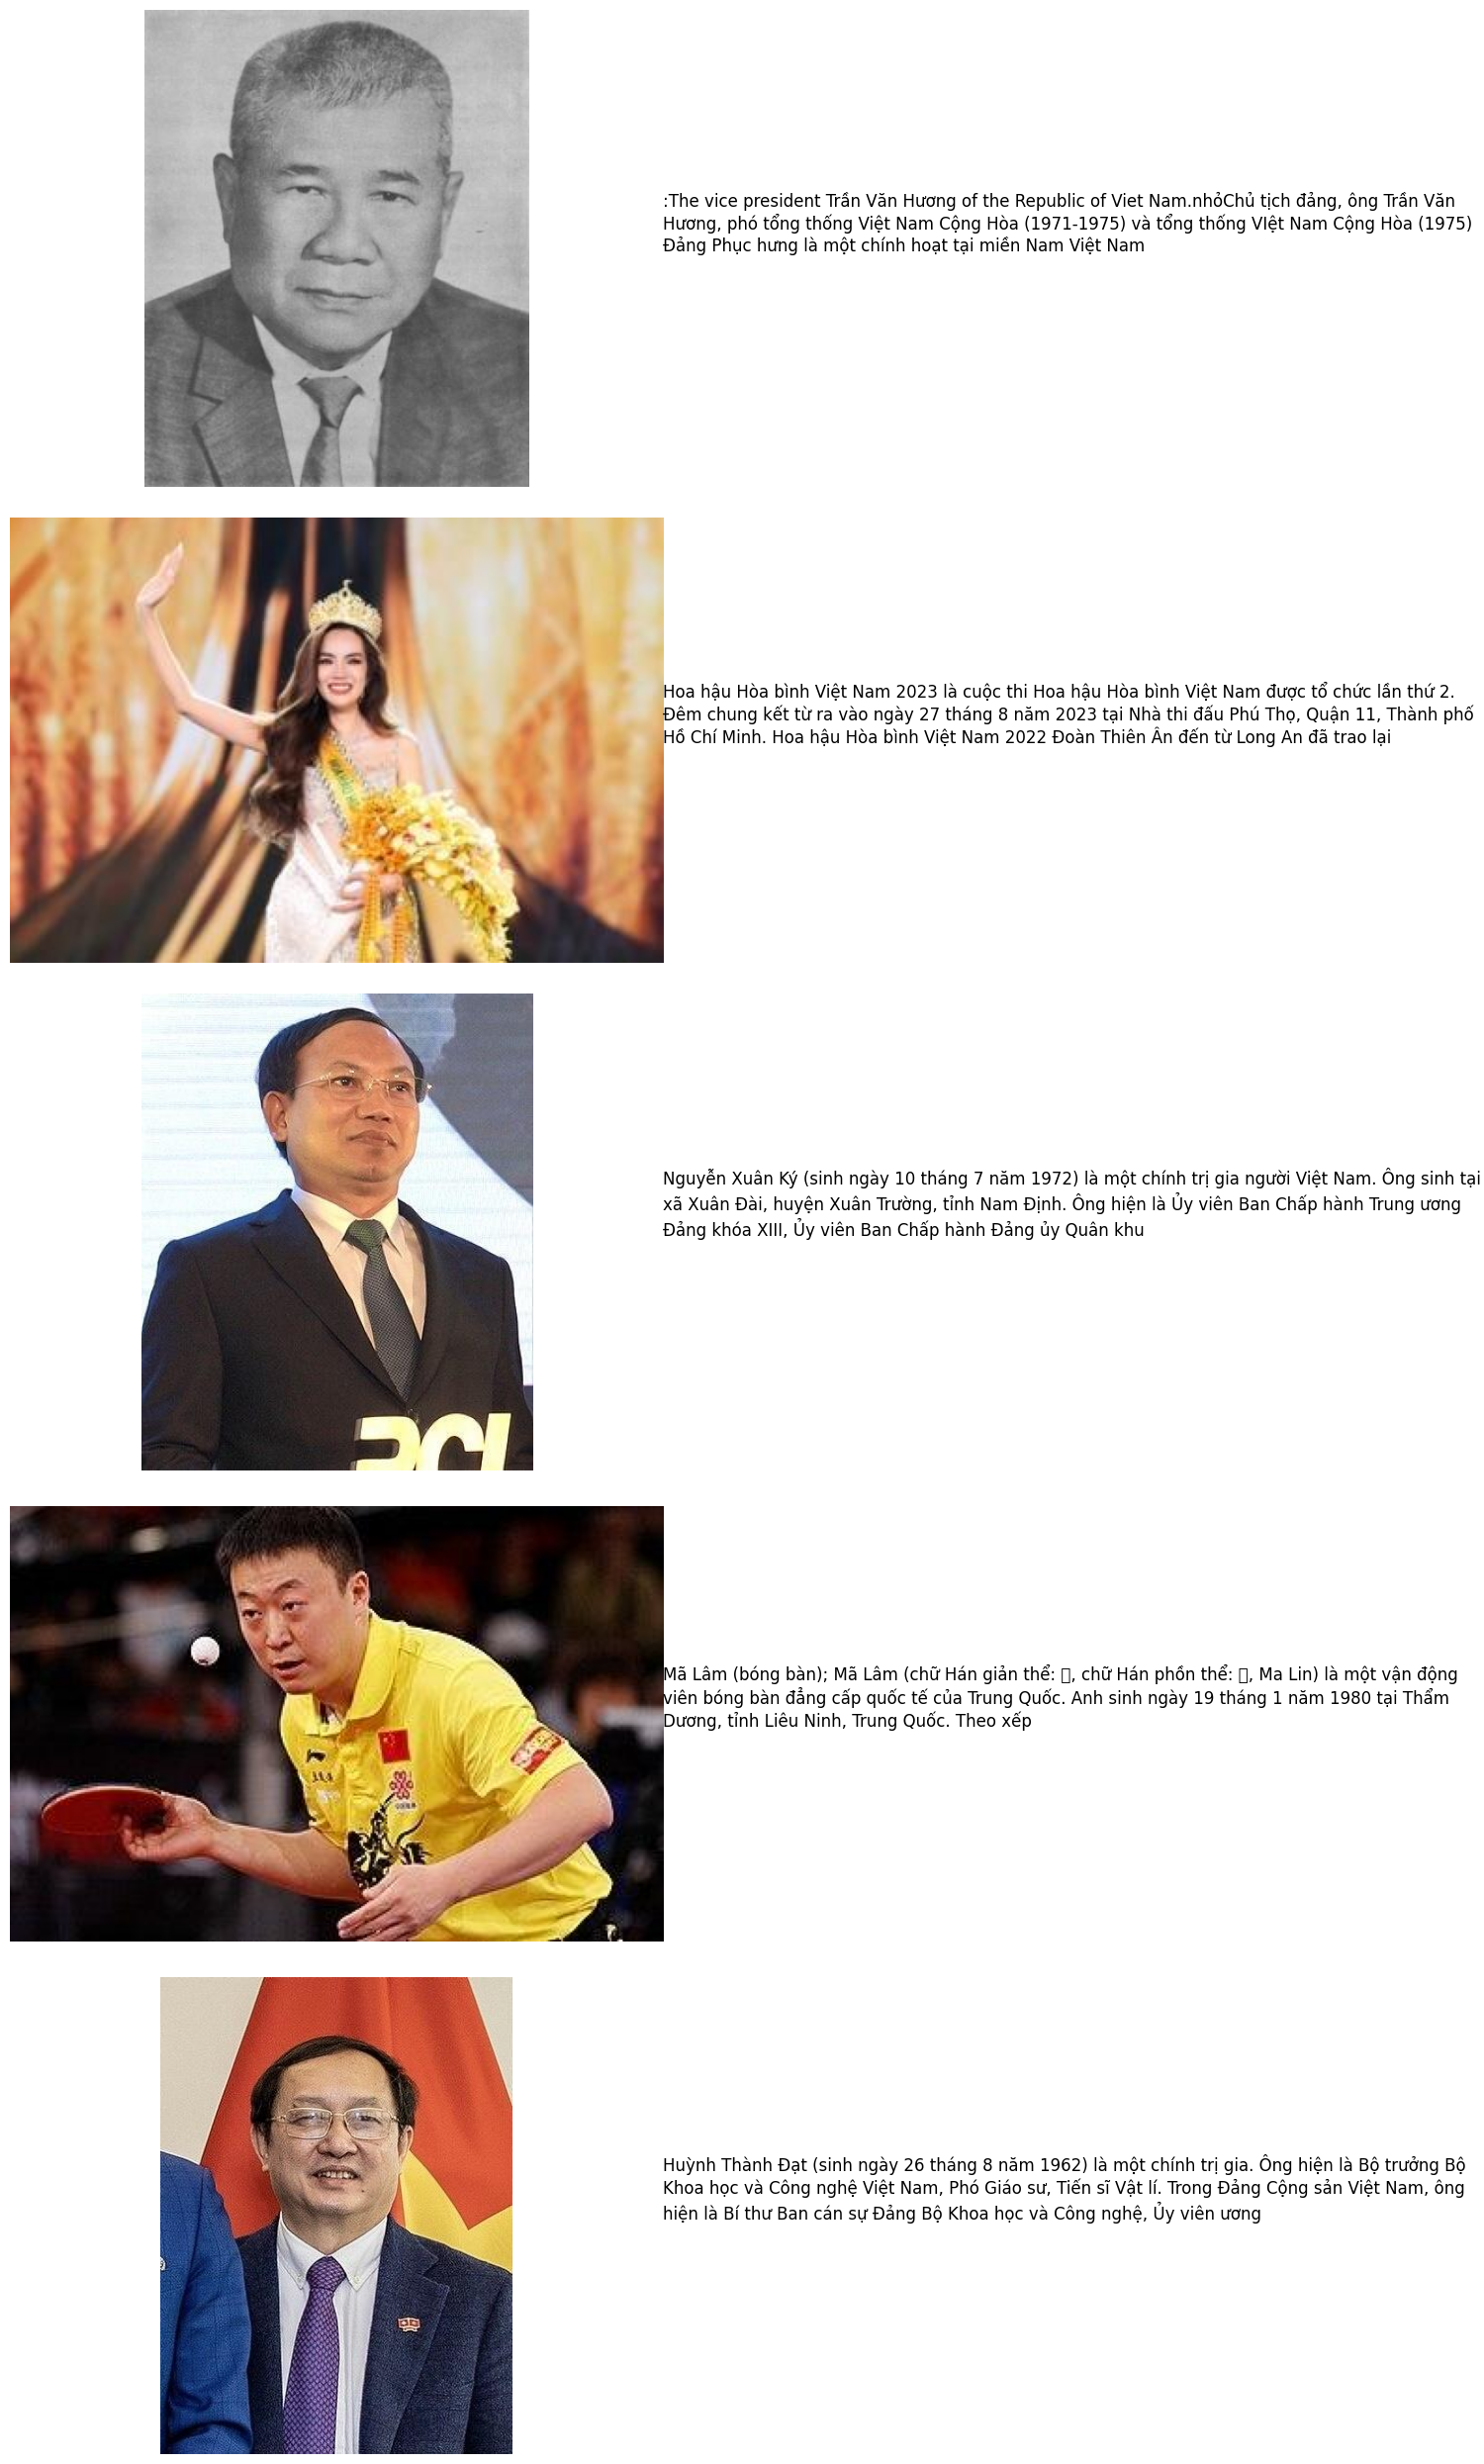

Plot saved as /kaggle/working/generated_captions.png


In [13]:
# Run the function
generate_caption(model, dataset, phobert_tokenizer, device,5,70)